<a href="https://colab.research.google.com/github/Biruk-gebru/RNNTraining-/blob/main/RNNTask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()


In [2]:
import os
import zipfile

# Setup kaggle API credentials
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d kaggle/us-baby-names

# Unzip the file
!unzip us-baby-names.zip -d baby_names


Dataset URL: https://www.kaggle.com/datasets/kaggle/us-baby-names
License(s): CC0-1.0
 70% 121M/173M [00:00<00:00, 1.26GB/s]
100% 173M/173M [00:00<00:00, 1.12GB/s]
Archive:  us-baby-names.zip
  inflating: baby_names/NationalNames.csv  
  inflating: baby_names/NationalReadMe.pdf  
  inflating: baby_names/StateNames.csv  
  inflating: baby_names/StateReadMe.pdf  
  inflating: baby_names/database.sqlite  
  inflating: baby_names/hashes.txt   


In [3]:
import pandas as pd

df = pd.read_csv('baby_names/NationalNames.csv')
df = df.dropna(subset=['Name'])

# Sample check
print(df.head())
print(f"Total unique names: {df['Name'].nunique()}")


   Id       Name  Year Gender  Count
0   1       Mary  1880      F   7065
1   2       Anna  1880      F   2604
2   3       Emma  1880      F   2003
3   4  Elizabeth  1880      F   1939
4   5     Minnie  1880      F   1746
Total unique names: 93889


In [4]:
import string
import torch

# Setup allowed characters
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters)

# Unique cleaned names
def clean_name(name):
    return ''.join(c for c in name if c in all_letters)

names = df['Name'].unique()
names = [clean_name(name) for name in names if len(name) > 1]
names = list(set(names))

print(f"Cleaned total names: {len(names)}")


Cleaned total names: 93889


In [5]:
# Letter to index and tensor
def letter_to_index(letter):
    return all_letters.find(letter)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor


In [6]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return self.softmax(output), hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [10]:
import random
import torch.optim as optim

def random_training_pair():
    name = random.choice(names)
    name = name.strip()

    # Skip very short or invalid names
    if len(name) < 2:
        return random_training_pair()

    input_tensor = line_to_tensor(name[:-1])
    target_indices = [letter_to_index(c) for c in name[1:]]

    # Validate that target indices are in range
    if any(i >= n_letters or i < 0 for i in target_indices):
        print("⚠️ Invalid target index found in name:", name)
        return random_training_pair()

    target_tensor = torch.tensor(target_indices, dtype=torch.long)
    return input_tensor, target_tensor

criterion = nn.NLLLoss()
rnn = RNN(n_letters, 128, n_letters)
optimizer = optim.Adam(rnn.parameters(), lr=0.005)  # You can lower to 0.001 if needed

n_iters = 10000
print_every = 500
plot_every = 500
all_losses = []
total_loss = 0

for iter in range(1, n_iters + 1):
    input_tensor, target_tensor = random_training_pair()
    hidden = rnn.initHidden()

    optimizer.zero_grad()
    loss = 0

    for i in range(input_tensor.size(0)):
        output, hidden = rnn(input_tensor[i], hidden)
        loss += criterion(output, target_tensor[i].unsqueeze(0))

    loss.backward()

    # ✅ Gradient clipping to avoid exploding gradients
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=5)

    optimizer.step()

    loss_val = loss.item() / input_tensor.size(0)
    total_loss += loss_val

    # Optional spike monitoring
    if loss_val > 1e6:
        print(f"🔥 Spike at iteration {iter}: {loss_val:.2f}")

    if iter % print_every == 0:
        avg_loss = total_loss / print_every
        print(f"[{iter}] Loss: {avg_loss:.4f}")
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


[500] Loss: 2.9194
[1000] Loss: 2.6270
[1500] Loss: 2.5308
[2000] Loss: 2.4488
[2500] Loss: 2.4735
[3000] Loss: 2.4014
[3500] Loss: 2.3820
[4000] Loss: 2.3686
[4500] Loss: 2.3550
[5000] Loss: 2.4011
[5500] Loss: 2.3653
[6000] Loss: 2.3615
[6500] Loss: 2.3745
[7000] Loss: 2.3740
[7500] Loss: 2.3166
[8000] Loss: 2.3439
[8500] Loss: 2.3657
[9000] Loss: 2.4047
[9500] Loss: 2.3626
[10000] Loss: 2.3313


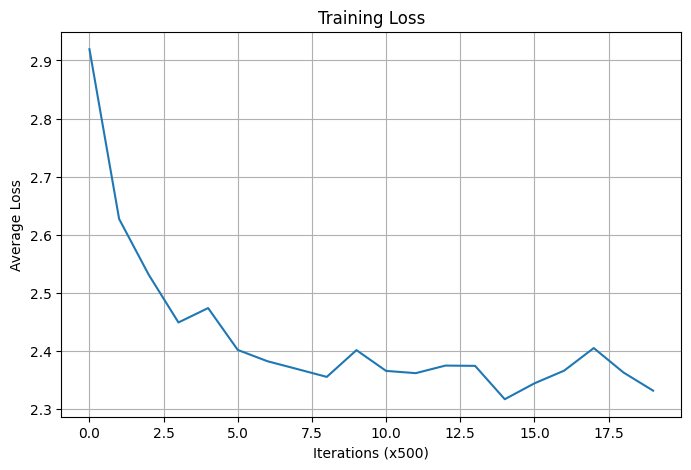

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(all_losses)
plt.title("Training Loss")
plt.xlabel("Iterations (x500)")
plt.ylabel("Average Loss")
plt.grid()
plt.show()


In [12]:
def generate(prefix='A', max_length=20):
    with torch.no_grad():
        input = letter_to_tensor(prefix[-1])
        hidden = rnn.initHidden()
        output_name = prefix

        for _ in range(max_length):
            output, hidden = rnn(input, hidden)
            topv, topi = output.topk(1)
            next_index = topi[0][0].item()
            next_char = all_letters[next_index]
            if next_char == '\n':
                break
            output_name += next_char
            input = letter_to_tensor(next_char)

        return output_name

# Generate names with different starting letters
for start in ["Ab", "Jo", "Lu", "Mar", "El"]:
    print(generate(start))


AberaviarandrvacrvdQvv
Jonderaneylanedrvadrvd
Luraneriahrayrvidrvndr
MarianenayrvicrvdQvvdQv
ElenellendrvidrvydrvdQ


In [13]:
torch.save(rnn.state_dict(), "name_generator_rnn.pth")


In [14]:
from google.colab import drive
drive.mount('/content/drive')

# Then copy to your drive
!cp name_generator_rnn.pth /content/drive/MyDrive/


Mounted at /content/drive
